# Traffic sign detection and classification (with deep learning)
Reset kernel

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!export CUDA_LAUNCH_BLOCKING=1

## Dependencies
Install dependencies. Adapt this to your linux distro/windows machine. Don't forget to restart the kernel to update the installed python packages.

In [1]:
%%capture
# Adapt adp-get to your distro
!pip install -U jupyter
!apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv unzip
!pip install opencv-python torchvision torchaudio albumentations kaggle tdqm torchsummary seaborn
!pip install --upgrade --quiet jupyter_client ipywidgets torchmetrics
!jupyter nbextension enable --py widgetsnbextension

Download dataset. I've created an account for this task, so please don't abuse this API key, thx.

In [2]:
%%capture
!mkdir -p ~/.kaggle
!echo "{\"username\":\"vcguy2022\",\"key\":\"58a013ff978771be5b85417b3ee3917c\"}"  > /root/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/road-sign-detection
!unzip road-sign-detection -d dataset/;

In [2]:
import cv2 as cv
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import numpy as np
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.functional import accuracy

Define your images and annotations directory here

In [3]:
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

Load train and val images and shuffle them

In [4]:
# Get train and validation datasets

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)

#displayImage(importImage(train_images_filenames[0])), displayImage(importImage(val_images_filenames[0]))
len(train_images_filenames), len(val_images_filenames)

(613, 264)

Define functions to visualize images

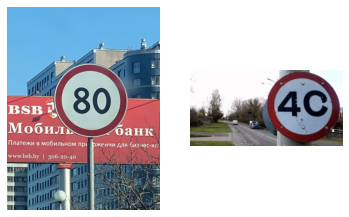

In [5]:
def importImage(name):
    from os import path
    image = cv.imread(path.join(images_directory, name + ".png"))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def displayImage(*names, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(names))
    for index, name in enumerate(names):
        axs[index].imshow(importImage(name))
        axs[index].axis('off')
    
    plt.title(title)
    plt.show()

displayImage(train_images_filenames[0], val_images_filenames[0])

## Load Dataset

For this, we define the classes that we want to predict and we define a dataset class, show bellow. It is assumed that all images have at least one sign, and as such, in the data augmentation section, no cropping transformations will be made.

In [151]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self.get_max_area_class_from_annotion(image_filename)

    def get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

Define simple transforms that normalize each image for each model

In [152]:
def transform_normalize(input_size, mean, std):
    train_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
        #A.RandomResizedCrop(input_size, input_size),
        #A.HorizontalFlip(),
    return train_transform, val_transform


Define batch size and num workers

In [153]:
batch_size = 64
num_workers = 0 # How many processes are used to load the data

Get dataloaders according to desired image size, which will vary according to the expected input size of the network

In [154]:
def get_dataloaders(input_size, mean, std, transform_f):
    train_transform, val_transform = transform_f(input_size, mean, std)
    train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader

Define device

In [155]:
num_classes = len(classes)

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Training

We define a model trainer class, which will help us to train each model more easily. This class trains a model for a given number of epochs, keeps track of the accuracy and loss of the model accross all epochs, and can save or load the model anytime

In [156]:
MODELS_DIR = "models"

class ModelTrainer:
    def __init__(self, *args):
        if len(args) == 5:
            model, model_name, loss, optimizer, device = args
        elif len(args) == 2:
            ks = ["model", "name", "num_epochs", "loss", "optimizer"]
            model, model_name, num_epochs, loss, optimizer = [args[0][k] for k in ks]
            device = args[1]

        self.model = model
        self.model_name = model_name
        self.curr_epoch = 0
        self.num_epochs = num_epochs # Epochs that each training session will have
        self.loss = loss
        self.optimizer = optimizer
        self.device = device
        self.scheduler = None
        self.accuracies = {}

    def predict_data(self, data):
        print("Predicting data")
        preds = []
        actuals = []
        with torch.set_grad_enabled(False):
            for _, (X, y) in enumerate(tqdm(data)):
                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = self.activation_out(probs)
                preds.extend(final_pred)
                actuals.extend(y)
        return torch.stack(preds, dim=0), torch.stack(actuals, dim=0)

    def _epoch_iter(self, dataloader, is_train, progress_bar=False):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            data = tqdm(dataloader) if progress_bar else dataloader
            for batch, (X, y) in enumerate(data):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred.cpu().numpy())
                labels.extend(y.cpu().numpy())

        metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        # metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        return total_loss / num_batches, metrics
    
    def _save_model(self, t, file_name):
        import os
        os.makedirs(MODELS_DIR, exist_ok=True)

        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        
        save_dict = {'model': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_path)

        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        with open(acc_path, 'w') as f:
            f.write(json.dumps(self.accuracies))

    def load_model(self, file_name):
        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        dic = torch.load(model_path)
        self.model.load_state_dict(dic['model'])
        self.model.eval()
        
        with open(acc_path, 'r') as f:
            self.accuracies = json.load(f)

        print(f"Loaded { self.model_name } obtained in epoch { dic['epoch'] }")

    def append_history(self, stage, train_data, val_data):
        train_loss, train_metrics = train_data
        val_loss, val_metrics = val_data
        self.accuracies[stage] = {
            "train": {
                "loss": train_loss,
                "metrics": train_metrics
            },
            "val": {
                "loss": val_loss,
                "metrics": val_metrics
            },         
        }

    def reset_accuracy(self):
        self.accuracies = {}
    
    def get_best_score(self):
        def get_score(node):
            return node["val"]["metrics"]["accuracy"]
        
        m_acc, m_stage = 0, ""
        for stg in self.accuracies:
            acc = get_score(self.accuracies[stg])
            if acc > m_acc:
                m_acc = acc
                m_stage = stg
        return m_acc, m_stage

    def set_scheduler(self, scheduler, gamma):
        if scheduler != None:
            self.scheduler = scheduler(self.optimizer, gamma)

    def train(self, train_dataloader, validation_dataloader, stage, progress_bar=False):
        # Stage => String identifier of the training iteration. Is used to identify between
        # the same model being trained at different contexts (exº fine tunning)
        accuracies = []
        train_history = {'loss': [], 'accuracy': []}
        val_history = {'loss': [], 'accuracy': []}
        best_val_loss = np.inf
        print("Start training...")

        for _ in range(self.num_epochs):
            t = self.curr_epoch
            print(f"\nEpoch {t}", end=" - ")

            # Train
            train_loss, train_metrics = self._epoch_iter(train_dataloader, True, progress_bar)
            train_acc = train_metrics["accuracy"]

            print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}", end=" - ")

            # Test
            val_loss, val_metrics = self._epoch_iter(validation_dataloader, False, progress_bar)
            val_acc = val_metrics["accuracy"]
            print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")
            
            # If scheduler exists, update lr
            if self.scheduler != None:
                self.scheduler.step()

            # save training history for plotting purposes
            self.append_history(
                f'{stage}_{t}',
                (train_loss, train_metrics),
                (val_loss, val_metrics)
            )

            # Save model when validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model(f'{stage}_{t}', 'best_model')

            # Save latest model
            self._save_model(f'{stage}_{t}', 'latest_model')
            self.curr_epoch += 1
            
        print("Finished")

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_fc(self):
        if hasattr(self.model, 'classifier'):
            last_item_index = len(self.model.classifier)-1
            layer = self.model.classifier.__getitem__(last_item_index)
            layer.weight.requires_grad = True
        elif hasattr(self.model, 'fc'):
            self.model.fc.weight.requires_grad = True

    def visualize_model(self, val_dataloader, classes, num_images=6): # Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
        was_training = self.model.training
        self.model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    class_names = list(classes.keys())
                    ax.set_title(f'predicted: {class_names[preds[j]]}')
                    cv.imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        self.model.train(mode=was_training)
                        return
            self.model.train(mode=was_training)

The function bellow will plot the accuracy and loss of a training session

In [157]:
def plotTrainingHistory(accuracies, session):
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    classes_pre = {c:[] for c in classes}
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["metrics"]["accuracy"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["metrics"]["accuracy"])
        for c in classes_pre:
            pre = epoch_acc["val"]["metrics"][str(classes[c])]["precision"]
            classes_pre[c].append(pre)

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.legend(loc='best')
    plt.show()

    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(20)
    plt.subplot(4, 1, 2)
    plt.title('Per Class Precision')
    for c in classes:  
        plt.plot(classes_pre[c], label=c)
    plt.legend(loc='best')
    plt.show()

And the function bellow will be used to try and load an existing model so that we don't have to retrain it when running the notebook

In [158]:
def load_model(trainer): # Returns True if success
    import os
    path = os.path.join(MODELS_DIR, trainer.model_name + '_best_model.pth')
    file_exists = os.path.exists(path)
    if not file_exists:
        print("Saved model not found, training instead.")
        return False
    else:
        trainer.load_model("best_model")
        return True


### ResNet-50
ResNet-50 expects an input size of 224, and expects images to be normalized according to the following mean and std values. We use these values to retrieve the dataloaders. In this initial setup, we will only normalize each image. Data augmentation will be tinkered with later.

In [159]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)

Charactarize training and validation sets

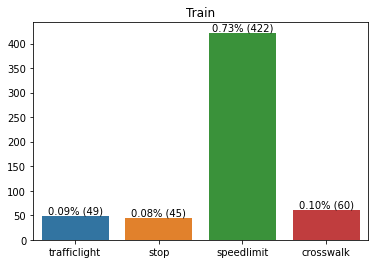

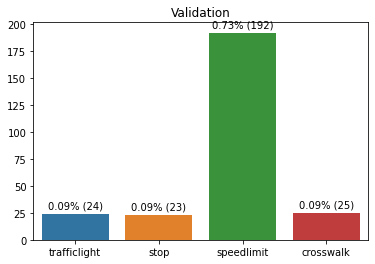

In [160]:
def describe_dataloader(dataloader, title):
    train_vals = np.array([])
    for batch, (X, y) in enumerate(dataloader):
        train_vals = np.append(train_vals, y.numpy())

    freqs = {c:np.count_nonzero(train_vals == classes[c]) for c in classes}
    keys = list(freqs.keys())
    vals = [int(freqs[k]) for k in keys]
    s = sum(vals)
    labels = [val / s for val in vals]
    labels = [f"{labels[i]:.2f}% ({vals[i]})" for i in range(len(labels))]
    ax = sns.barplot(x=keys, y=vals)
    patches = ax.patches
    ax.set_title(title)
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+5
        ax.annotate(labels[i], (x, y), ha='center')
    plt.show()

describe_dataloader(train_dataloader, "Train"), describe_dataloader(val_dataloader, "Validation");

As can be seen, the speedlimit class is clearly the most predominant sign with the highest area across all images. This predominance is present on both validation and train sets. 

#### Transfer Learning

We define a pretrained ResNet-50 as our baseline, with 10 epochs, cross entropy loss, and SGD optimizer. We will compare all models with this one.

In [161]:
resnet_model_trained = models.resnet50(pretrained=True)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_trained.to(device)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_pretrained',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-2),
}

#summary(resnet["model"], (3, input_size, input_size))

First we do **transfer learning** - train only the last layer while freezing all others.

In [162]:
resnet_trainer = ModelTrainer(resnet_trained, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    need_train = True
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

plotTrainingHistory(resnet_trainer.accuracies, "frozen")

Start training...

Epoch 0 - Train loss: 0.908 	 Train acc: 0.696 - 

KeyboardInterrupt: 

We can see that the model can distinguish most of the speedlimit signs, while not knowing how to deal with crosswalks or trafficlights. During the last epochs the model seems to have learned how to identify stop signs.

Perform **fine tunning** - unfreeze all layers and train with a small learning rate a small number of epochs. We expect better fine tuned results after this.

In [ ]:
resnet_trainer.optimizer = torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-6)
resnet_trainer.num_epochs = 3 
resnet_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    resnet_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistory(resnet_trainer.accuracies, "fine_tuning")

As we can see, our best result was 0.754, which we consider satisfactory as the learning rate is fixed and we are applying few data augmentation. In addition, fine tunning has given the model the capability to distinguish crosswalk signs, but traffic lights are still not being detected.

Now let's bundle this into a function that does the transfer learning process

In [57]:
def transfer_learn(name, model,
                   opt_freeze, lr_freeze, ep_freeze,
                   opt_fine_tune, lr_fine_tune, ep_fine_tune,
                   load,
                   scheduler_freeze=None, scheduler_fine_tune=None,
                   scheduler_gamma_freeze=None, scheduler_gamma_fine_tune=None):

    # change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
    if hasattr(model, 'classifier'):
        last_item_index = len(model.classifier)-1
        old_fc = model.classifier.__getitem__(last_item_index)
        new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
        model.classifier.__setitem__(last_item_index , new_fc)
    elif hasattr(model, 'fc'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model.to(device)

    model_d = {
        "model": model,
        "name": name,
        #"num_epochs": 50,
        "num_epochs": ep_freeze,
        "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
        "optimizer": opt_freeze(model.parameters(), lr=lr_freeze)
    }

    trainer = ModelTrainer(model_d, device)
    trainer.set_scheduler(scheduler_freeze, scheduler_gamma_freeze)
    # Unfreeze all layers expect last
    trainer.freeze_layers()
    trainer.unfreeze_fc()

    # Training can be skipped by loading the best model until now
    if load:
        need_train = (load_model(trainer) == False)
    if not load or need_train:
        need_train = True
        trainer.train(train_dataloader, val_dataloader, "frozen")

    trainer.optimizer = opt_fine_tune(model.parameters(), lr=lr_fine_tune)
    trainer.set_scheduler(scheduler_fine_tune, scheduler_gamma_fine_tune)
    trainer.num_epochs = ep_fine_tune
    trainer.unfreeze_layers()

    if need_train: # Train if previous cell has trained too
        trainer.train(train_dataloader, val_dataloader, "fine_tuning")

    plotTrainingHistory(trainer.accuracies, "frozen")
    plotTrainingHistory(trainer.accuracies, "fine_tuning")
    return trainer


##### **Optimizer Tuning**

Now we will experiment with different optimizers and compare results

In [59]:
# Adam optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adam_best_score = trainer.get_best_score()
adam_best_score

Saved model not found, training instead.
Start training...

Epoch 0 - Train loss: 2.933 	 Train acc: 0.580 - Val loss: 1.495 	 Val acc: 0.481

Epoch 1 - 

KeyboardInterrupt: 

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.901 	 Train acc: 0.484


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.349 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.332 	 Train acc: 0.679


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.597 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.438 	 Train acc: 0.703


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.067 	 Val acc: 0.723


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.775 	 Train acc: 0.767


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.873 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.653 	 Train acc: 0.800


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.922 	 Val acc: 0.750


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.654 	 Train acc: 0.785


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.715 	 Val acc: 0.780


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.633 	 Train acc: 0.792


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.625 	 Val acc: 0.773


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.592 	 Train acc: 0.835


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.545 	 Val acc: 0.788


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.565 	 Train acc: 0.819


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Val loss: 0.511 	 Val acc: 0.803


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.525 	 Train acc: 0.839


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.462 	 Val acc: 0.818


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.525 	 Train acc: 0.814


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.440 	 Val acc: 0.837


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.507 	 Train acc: 0.825


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.436 	 Val acc: 0.848


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.498 	 Train acc: 0.835


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.427 	 Val acc: 0.841
Finished


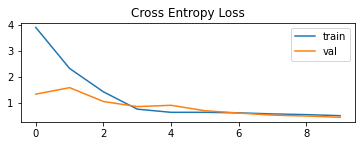

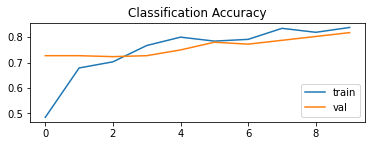

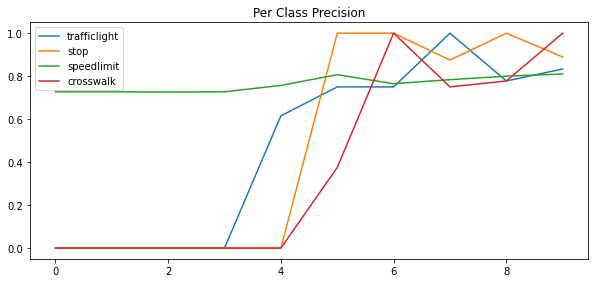

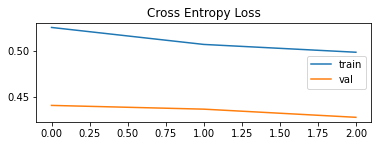

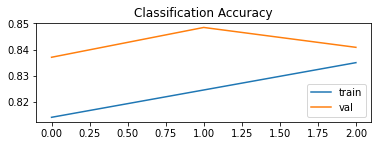

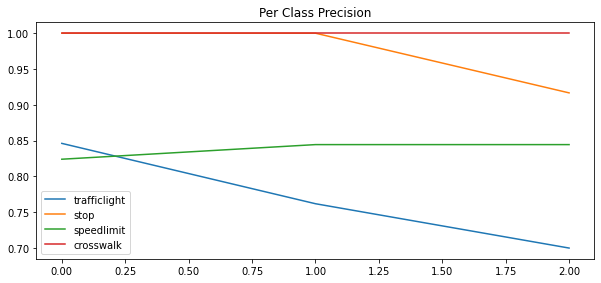

(0.8484848484848485, 'fine_tuning_11')

In [27]:
# Adamax optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adamax",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adamax,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adamax,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adamax_best_score = trainer.get_best_score()
adamax_best_score

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 25.876 	 Train acc: 0.514


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 16.327 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 16.075 	 Train acc: 0.594


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 9.643 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 7.579 	 Train acc: 0.653


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Val loss: 4.665 	 Val acc: 0.621


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.381 	 Train acc: 0.615


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Val loss: 11.231 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 6.355 	 Train acc: 0.694


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 3.434 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.314 	 Train acc: 0.743


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.734 	 Val acc: 0.739


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.798 	 Train acc: 0.729


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 2.001 	 Val acc: 0.765


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.165 	 Train acc: 0.766


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 2.014 	 Val acc: 0.735


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.223 	 Train acc: 0.705


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 4.236 	 Val acc: 0.742


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.291 	 Train acc: 0.656


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 6.460 	 Val acc: 0.754


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.678 	 Train acc: 0.769


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 5.326 	 Val acc: 0.758


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.492 	 Train acc: 0.759


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 4.976 	 Val acc: 0.765


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.207 	 Train acc: 0.766


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 4.431 	 Val acc: 0.765
Finished


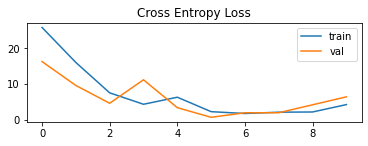

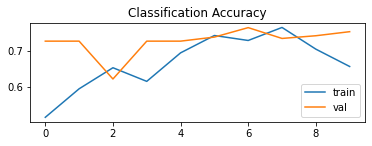

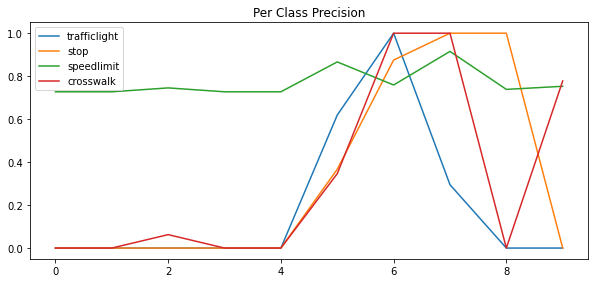

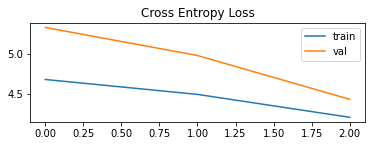

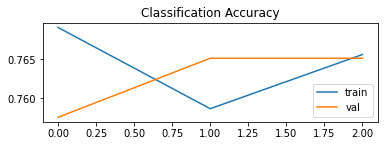

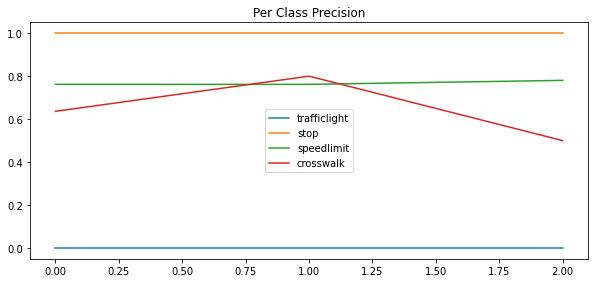

(0.7651515151515151, 'frozen_6')

In [28]:
# RMSprop optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_rmsprop",
    model=resnet_model_trained,
    opt_freeze=torch.optim.RMSprop,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.RMSprop,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
rmsprop_best_score = trainer.get_best_score()
rmsprop_best_score

In [29]:
adam_best_score, adamax_best_score, rmsprop_best_score

((0.8787878787878788, 'frozen_8'),
 (0.8484848484848485, 'fine_tuning_11'),
 (0.7651515151515151, 'frozen_6'))

As can be seen, the optimizer that provided the best results was adam. It increased accuracy from 75% to 85%.

#### **Learning Rate Scheduler**

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.839 	 Train acc: 0.543


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.951 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.942 	 Train acc: 0.569


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 2.249 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.804 	 Train acc: 0.773


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Val loss: 2.043 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.917 	 Train acc: 0.783


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.121 	 Val acc: 0.549


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.751 	 Train acc: 0.809


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.155 	 Val acc: 0.723


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.622 	 Train acc: 0.818


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.564 	 Val acc: 0.795


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.554 	 Train acc: 0.812


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val loss: 0.558 	 Val acc: 0.807


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.530 	 Train acc: 0.819


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Val loss: 0.494 	 Val acc: 0.830


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.550 	 Train acc: 0.821


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.471 	 Val acc: 0.845


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.487 	 Train acc: 0.851


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.449 	 Val acc: 0.837


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.498 	 Train acc: 0.833


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.425 	 Val acc: 0.860


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.490 	 Train acc: 0.849


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.405 	 Val acc: 0.871


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.517 	 Train acc: 0.835


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.409 	 Val acc: 0.871
Finished


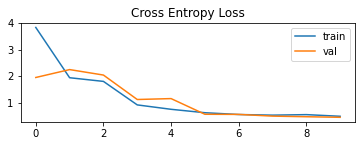

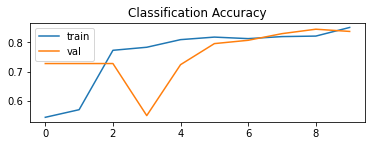

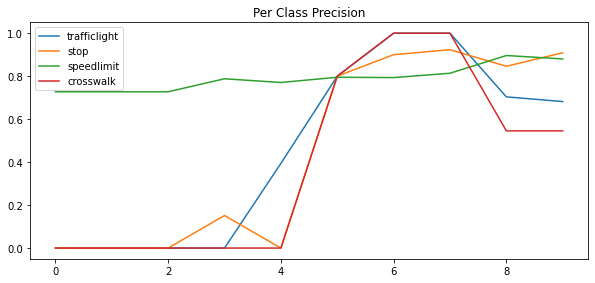

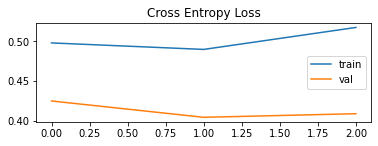

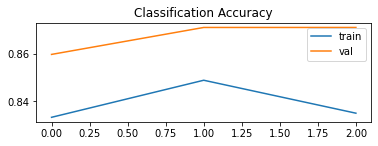

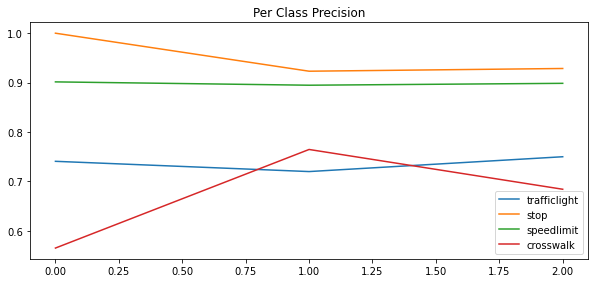

(0.8712121212121212, 'fine_tuning_11')

In [30]:
# ExpLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam_expLR",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_fine_tune=0.9,
    load=True
)
expLR_best_score = trainer.get_best_score()
expLR_best_score

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.737 	 Train acc: 0.505


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 2.123 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.854 	 Train acc: 0.686


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 1.423 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.161 	 Train acc: 0.648


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.922 	 Val acc: 0.299


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.934 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 1.086 	 Val acc: 0.542


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.726 	 Train acc: 0.797


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.118 	 Val acc: 0.576


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.596 	 Train acc: 0.804


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.636 	 Val acc: 0.814


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.545 	 Train acc: 0.816


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.494 	 Val acc: 0.833


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.518 	 Train acc: 0.837


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.513 	 Val acc: 0.848


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.503 	 Train acc: 0.828


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.502 	 Val acc: 0.841


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.501 	 Train acc: 0.837


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.414 	 Val acc: 0.848


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.460 	 Train acc: 0.839


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.408 	 Val acc: 0.856


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.495 	 Train acc: 0.835


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.389 	 Val acc: 0.852


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.451 	 Train acc: 0.847


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Val loss: 0.384 	 Val acc: 0.864
Finished


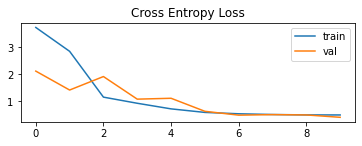

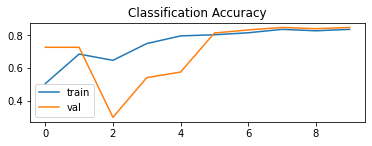

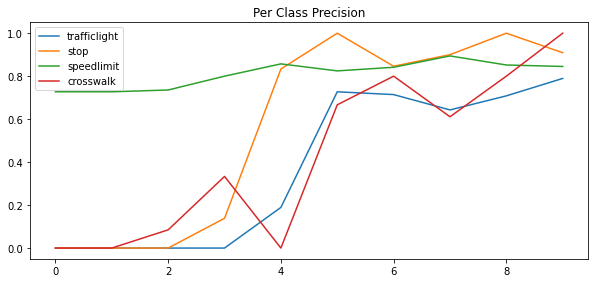

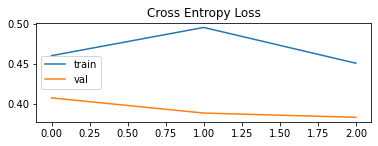

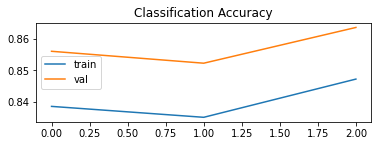

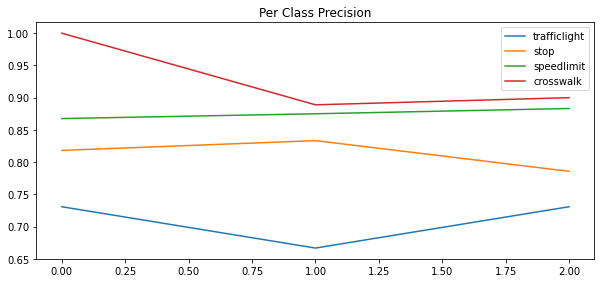

(0.8636363636363636, 'fine_tuning_12')

In [31]:
# StepLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam_stepLR",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_fine_tune=0.9,
    load=True
)
stepLR_best_score = trainer.get_best_score()
stepLR_best_score

In [32]:
rmsprop_best_score

(0.7651515151515151, 'frozen_6')

ExpLR had the best results, with an increase of 3% in accuracy

#### Train from scratch

Now let's train the network from **scratch**, with the same hyperparams except learning rate, which was increased to get to the minima faster.

  0%|          | 0/9 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.495 	 Train acc: 0.651


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 716060.906 	 Val acc: 0.091


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.273 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 140413.288 	 Val acc: 0.083


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.884 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 1004.070 	 Val acc: 0.689


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.920 	 Train acc: 0.759


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 9.044 	 Val acc: 0.735


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.847 	 Train acc: 0.748


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 0.709 	 Val acc: 0.761


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.771 	 Train acc: 0.740


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 0.623 	 Val acc: 0.746


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.747 	 Train acc: 0.762


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 1.584 	 Val acc: 0.723


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.796 	 Train acc: 0.752


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Val loss: 0.801 	 Val acc: 0.758


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.841 	 Train acc: 0.750


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Val loss: 0.658 	 Val acc: 0.761


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.701 	 Train acc: 0.748


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Val loss: 0.669 	 Val acc: 0.754
Finished


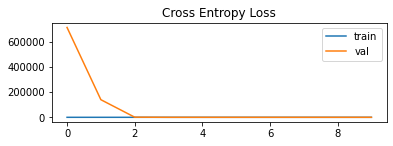

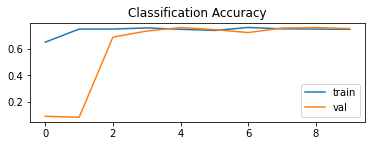

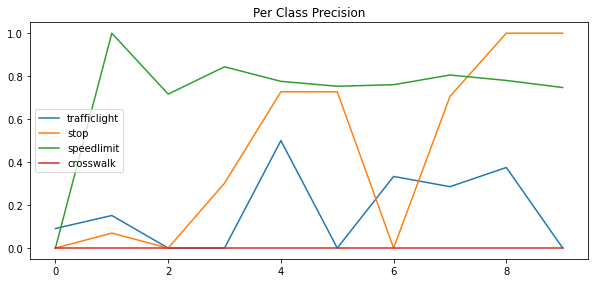

(0.7613636363636364, 'scratch_4')

In [128]:
resnet_model_scratch = models.resnet50(pretrained=False)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_scratch.fc.in_features
resnet_model_scratch.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_scratch.to(device)

resnet_scratch = {
    "model": resnet_model_scratch,
    "name": 'resnet50_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.Adam(resnet_model_scratch.parameters(), lr=0.01),
}

resnet_trainer = ModelTrainer(resnet_scratch, device)
# Unfreeze all layers
resnet_trainer.unfreeze_layers()
resnet_trainer.set_scheduler(torch.optim.lr_scheduler.StepLR, gamma=0.9)

load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)

if not load or need_train:
    resnet_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(resnet_trainer.accuracies, "scratch")
resnet_trainer.get_best_score()

The group was surprised with the results being so high (76%), we were expecting a lower accuracy.

### VGG-16

VGG-16 Expects the same input size and normalization as ResNet-50, so it will be the same. In this brief section we will only train this network two times: with transfer learning and from scratch. This process is the same to what was done with resnet.

In [60]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)
vgg_model_pretrained = models.vgg16(pretrained=True)

trainer = transfer_learn(
    name="resnet50_pretrained_adam_stepLR",
    model=vgg_model_pretrained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.StepLR,
    scheduler_gamma_fine_tune=0.9,
    load=False
)
vgg_best_score = trainer.get_best_score()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Start training...

Epoch 0 - Train loss: 2.285 	 Train acc: 0.668 - Val loss: 0.867 	 Val acc: 0.814

Epoch 1 - 

KeyboardInterrupt: 

Training from scratch

  0%|          | 0/9 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.384 	 Train acc: 0.252


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.387 	 Train acc: 0.257


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.250


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.385 	 Train acc: 0.220


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.385 	 Train acc: 0.229


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.385 	 Train acc: 0.238


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.207


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.220


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.386 	 Train acc: 0.224


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val loss: 1.377 	 Val acc: 0.125


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.384 	 Train acc: 0.233


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val loss: 1.377 	 Val acc: 0.125
Finished


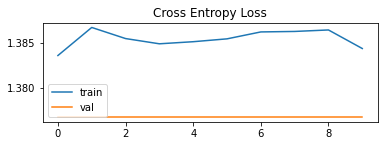

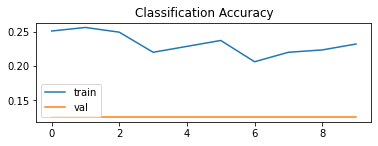

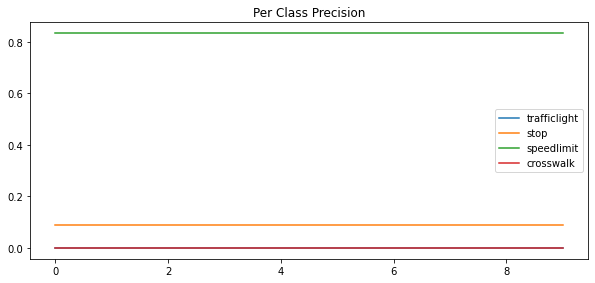

(0.125, 'scratch_0')

In [132]:
vgg_model_scratch = models.vgg16(pretrained=False)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
last_item_index = len(vgg_model_scratch.classifier)-1
old_fc = vgg_model_scratch.classifier.__getitem__(last_item_index)
new_fc = nn.Linear(in_features=old_fc.in_features, out_features= num_classes, bias=True)
vgg_model_scratch.classifier.__setitem__(last_item_index , new_fc)
vgg_model_scratch.to(device)

vgg_scratch = {
    "model": vgg_model_scratch,
    "name": 'vgg_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.Adam(resnet_model_scratch.parameters(), lr=0.01),
}

vgg_trainer = ModelTrainer(vgg_scratch, device)
# Unfreeze all layers
vgg_trainer.unfreeze_layers()
vgg_trainer.set_scheduler(torch.optim.lr_scheduler.StepLR, gamma=0.9)

load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(vgg_trainer) == False)
if not load or need_train:
    vgg_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(vgg_trainer.accuracies, "scratch")
vgg_trainer.get_best_score()

As we can see the results were extremly poor. We don't know why there is a huge descrepancy between this value and the accuracy achieved by Resnet from scratch (75%)

## Data Augmentation

The experimented data augmentation methods can be seen bellow. Different combintations were tried, and these were chosen due to them giving better results. 

In [40]:
def transform_data(input_size, mean, std):
    train_transform = A.Compose([
        A.RandomScale(scale_limit=0.5, interpolation=1, p=0.2),
        A.Rotate(limit=40, interpolation=1, p=0.2),
        A.ElasticTransform(p=0.1),
        A.HorizontalFlip(p=0.2),
        A.Downscale(scale_min=0.25, scale_max=0.25, p=0.1),
        A.RandomBrightnessContrast(p=0.2),
        A.OneOf([ # Noise
            A.GaussNoise(p=0.3),
            A.ImageCompression(p=0.2, quality_lower=20, quality_upper=70),
            A.Sharpen(p=0.3)
        ], p=0.2),
        A.OneOf([ # Distortion
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([ # Blurring
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([ # Color
            A.ToGray(p=0.2),
            A.ToSepia(p=0.2),
            A.RGBShift(r_shift_limit=40, g_shift_limit=60, b_shift_limit=40, p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        ], p=0.2),
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
        #A.RandomResizedCrop(input_size, input_size),
        #A.HorizontalFlip(),
    return train_transform, val_transform

input_size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_data)

In [41]:
describe_dataloader(train_dataloader, "Train"), describe_dataloader(val_dataloader, "Validation");

NameError: name 'describe_dataloader' is not defined

Let's add these transformations with the best model, ResNet50 with ADAM and ExpLR with transfer learning.

In [19]:
expLR_best_score

NameError: name 'expLR_best_score' is not defined

  0%|          | 0/9 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.120 	 Train acc: 0.599


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Val loss: 1.557 	 Val acc: 0.769


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.861 	 Train acc: 0.776


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Val loss: 0.458 	 Val acc: 0.845


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.730 	 Train acc: 0.793


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Val loss: 0.412 	 Val acc: 0.875


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.532 	 Train acc: 0.818


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Val loss: 0.344 	 Val acc: 0.856


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.359 	 Train acc: 0.866


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 0.426 	 Val acc: 0.883


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.325 	 Train acc: 0.887


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 0.270 	 Val acc: 0.894


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.283 	 Train acc: 0.901


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 0.268 	 Val acc: 0.902


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.276 	 Train acc: 0.913


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Val loss: 0.276 	 Val acc: 0.894


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.255 	 Train acc: 0.915


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val loss: 0.282 	 Val acc: 0.883


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.282 	 Train acc: 0.903


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Val loss: 0.250 	 Val acc: 0.909


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.231 	 Train acc: 0.927


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Val loss: 0.247 	 Val acc: 0.913


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.232 	 Train acc: 0.932


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 0.242 	 Val acc: 0.917


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.209 	 Train acc: 0.944


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val loss: 0.237 	 Val acc: 0.913
Finished


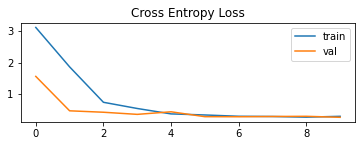

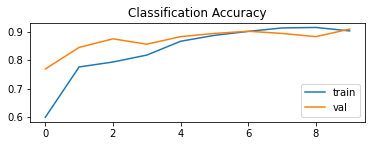

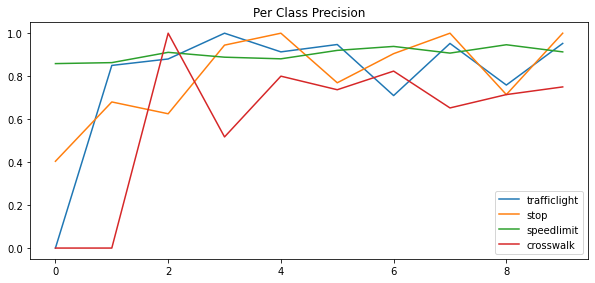

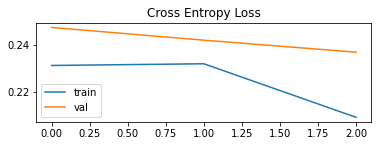

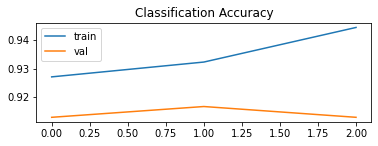

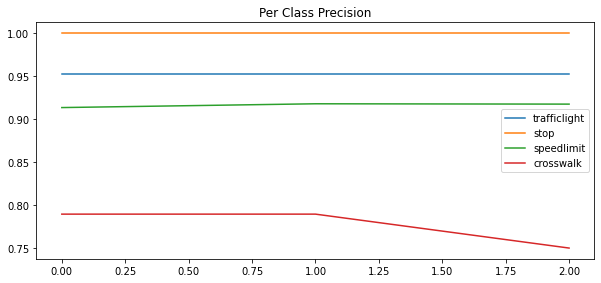

(0.9166666666666666, 'fine_tuning_11')

In [124]:
# ExpLR optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam_expLR_dataloader",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_fine_tune=0.9,
    load=False
)
data_aug_best_score = trainer.get_best_score()
data_aug_best_score

We can conclude that this greatly improves results, from 85% to 92%

## Multilabeling
First we need to redefine the dataset to take into consideration multiple labels. Instead of returning the biggest area class, we will be returing what types of signs the image has.

In [163]:
classes # Remember our target classes

{'trafficlight': 0, 'stop': 1, 'speedlimit': 2, 'crosswalk': 3}

In [176]:
class TrafficSignDatasetMultiLabel(TrafficSignDataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self.get_classes_from_annotation(image_filename)

    def get_classes_from_annotation(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            c = torch.zeros(num_classes)
            objects = root.findall("object")
            for object in objects:
                c_name = object.find("name").text
                if c_name in classes and c[classes[c_name]] == 0:
                    c[classes[c_name]] = 1

        return c

input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_normalize)

We will redefine de ModelTrainer class to take into account multiple labels. This implies using a sigmoid in the predictions 

In [181]:
MODELS_DIR = "models"

class ModelTrainerMultiLabel(ModelTrainer):
    def __init__(self, args, device):
        super().__init__(args, device) 

    def _epoch_iter(self, dataloader, is_train, progress_bar=False):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            data = tqdm(dataloader) if progress_bar else dataloader
            for batch, (X, y) in enumerate(data):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                pred = F.sigmoid(pred)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                preds.append(pred.cpu().detach())
                labels.append(y.cpu().detach())

        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        preds = preds.int()
        labels = labels.int()
        acc = accuracy(preds, labels, num_classes=4, average="macro", multiclass=False)

        metrics = {
            'accuracy': acc.item()
        }

        # metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        return total_loss / num_batches, metrics

In [188]:
def get_dataloaders_multilabel(input_size, mean, std, transform_f): # Same as above but we use the multilabel dataset
    train_transform, val_transform = transform_f(input_size, mean, std)
    train_dataset = TrafficSignDatasetMultiLabel(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDatasetMultiLabel(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std, transform_data)

In [189]:
def plotTrainingHistoryMultilabel(accuracies, session): # Only plots accuracy
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["metrics"]["accuracy"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["metrics"]["accuracy"])

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.legend(loc='best')
    plt.show()

Loaded resnet50_pretrained obtained in epoch frozen_6


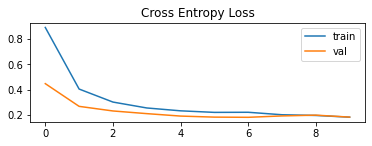

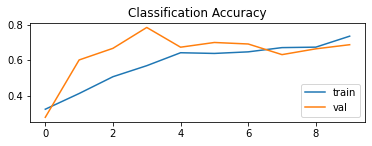

(0.7854161858558655, 'frozen_3')

In [187]:
resnet_model_trained = models.resnet50(pretrained=True)
# number of neurons in the last layer to the number of classes is the same
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=4, bias=True)
resnet_model_trained.to(device)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_pretrained',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.BCELoss(),
    "optimizer": torch.optim.Adam(resnet_model_trained.parameters(), lr=1e-2)
}

resnet_trainer = ModelTrainerMultiLabel(resnet_trained, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = True # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    need_train = True
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

plotTrainingHistoryMultilabel(resnet_trainer.accuracies, "frozen")
resnet_trainer.get_best_score()